### Comparation between LinearSVC, SVC, and SGDClassifier

In [1]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [2]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                       max_iter=100000, tol=-np.infty, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC: ", lin_clf.intercept_, lin_clf.coef_)
print("SVC: ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}): ".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:  [0.28474272] [[1.05364736 1.09903308]]
SVC:  [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200):  [0.319] [[1.12087283 1.02679408]]


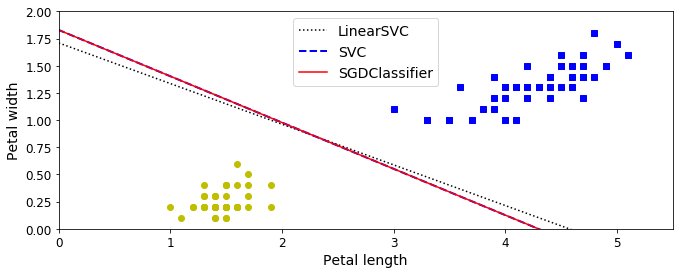

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Compute the slope and bias of each decision boundary
slope1 = -lin_clf.coef_[0,0]/lin_clf.coef_[0,1]
bias1 = -lin_clf.intercept_[0]/lin_clf.coef_[0,1]
slope2 = -svm_clf.coef_[0,0]/svm_clf.coef_[0,1]
bias2 = -svm_clf.intercept_[0]/svm_clf.coef_[0,1]
slope3 = -sgd_clf.coef_[0,0]/sgd_clf.coef_[0,1]
bias3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0,1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * slope1 + bias1], [10, 10 * slope1 + bias1]])
line2 = scaler.inverse_transform([[-10, -10 * slope2 + bias2], [10, 10 * slope2 + bias2]])
line3 = scaler.inverse_transform([[-10, -10 * slope3 + bias3], [10, 10 * slope3 + bias3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

### Train SVM Classifier on MNIST dataset

In [6]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST_original')

X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [8]:
# Shuffle training instance
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

In [9]:
# LinearSVM automatically using 1 vs all
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/home/rafi/Documents/ml/env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [11]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8946

In [13]:
# Try to improve accuracy by scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float32))

lin_clf.fit(X_train_scaled, y_train)
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

/home/rafi/Documents/ml/env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9215166666666667

In [16]:
# Train using SVM with rbf kernel
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9476

In [18]:
# Tune the hyperparameters since this model looks promising

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.1s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   30.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3522ab7f0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3522ab6a0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [19]:
rnd_search_cv.best_estimator_

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
rnd_search_cv.best_score_

0.864

In [21]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
y_pred = rnd_search_cv.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

In [24]:
y_pred = rnd_search_cv.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9705

### Train SVM Classifier on California housing dataset

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [5]:
# Train simple LinearSVR
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/home/rafi/Documents/ml/env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [6]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.949968822217229

In [8]:
np.sqrt(mse)

0.9746634404845752

In [9]:
# Train RBF kernel
# Randomized search to determine hyperparameter 'C' and 'gamma'

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   8.3s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   8.1s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   8.1s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   7.6s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   7.4s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   7.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   7.0s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   6.9s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe5f97a78d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe5f97a72e8>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [10]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785356

In [20]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

1.1066673077043268